In [5]:
import os
import re
from pathlib import Path
import csv
import numpy as np
import pandas as pd
from scipy import stats

from collections import defaultdict

import pydicom
from pydicom.data import get_testdata_file

# !pip install SimpleITK
import SimpleITK as sitk
from skimage import morphology
from scipy import ndimage


import cv2
import matplotlib.pyplot as plt

In [2]:
directory = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416"
file_name = "1-01.dcm"
file_path = os.path.join(directory, file_name)

if os.path.isdir(directory):
    print("Directory exists")

    print("Contents of the directory:")
    i=0
    for item in os.listdir(directory):
        while i<5:
            print(item)
            i = i+1
            break

    if os.path.exists(file_path):
        print(f"{file_name}File exists")
        
    else:
        print("File does not exist. Please check the file path.")
else:
    print("Directory does not exist. Please check the directory path.")


Directory exists
Contents of the directory:
1-81.dcm
1-42.dcm
1-56.dcm
1-57.dcm
1-43.dcm
1-01.dcmFile exists


In [5]:
file_name2 = "1-02.dcm"
file_path2 = os.path.join(directory, file_name2)

if os.path.isdir(directory):
    print("Directory exists")

    print("Contents of the directory:")
    i=0
    for item in os.listdir(directory):
        while i<5:
            print(item)
            i = i+1
            break

    if os.path.exists(file_path2):
        print(f"{file_name2}File exists")
        
    else:
        print("File does not exist. Please check the file path.")
else:
    print("Directory does not exist. Please check the directory path.")


Directory exists
Contents of the directory:
1-81.dcm
1-42.dcm
1-56.dcm
1-57.dcm
1-43.dcm
1-02.dcmFile exists


In [6]:
ds = pydicom.dcmread(file_path)
print(ds)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.1610.1211.142789310517751786980485018978
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.

In [26]:
def sort_csv_by_acquisition_time(input_path, output_path):
#     df = pd.read_csv(input_path, quoting=csv.QUOTE_MINIMAL, on_bad_lines='skip')
    df = pd.read_csv(input_path)

    df_sorted = df.sort_values(by="InstanceNumber")

    df_sorted.to_csv(output_path, index=False)
    

In [31]:
def flatten(ds, prefix=''):
    data = {}
    for elem in ds:
        if elem.VR == 'SQ':
            for i, item in enumerate(elem.value):
                item_data = flatten(item, prefix=f"{prefix}{elem.keyword}[{i}].")
                data.update(item_data)
        else:
            data[f"{prefix}{elem.keyword}"] = str(elem.value)
    return data

def extract_metadata(file):
    # Dummy implementation - replace with your actual metadata extraction logic
    try:
        # Assume this function reads a DICOM file and extracts metadata including pixel data.
        metadata = {"DummyKey": "DummyValue"}
        max_intensity = 100
        min_intensity = 0
        mean_intensity = 50
        median_intensity = 50
        return metadata, max_intensity, min_intensity, mean_intensity, median_intensity
    except Exception as e:
        raise RuntimeError(f"Unable to process {file}: {e}")

In [34]:
import os
import csv
from pathlib import Path
import pydicom
import numpy as np
import pandas as pd

def extract_metadata(file):
    try:
        ds = pydicom.dcmread(file)
        metadata = {}
        for elem in ds.iterall():
            tag = pydicom.datadict.keyword_for_tag(elem.tag)
            if tag == '':
                tag = elem.tag
            metadata[tag] = elem.value
        try:
            pixel_array = ds.pixel_array
            max_intensity = pixel_array.max()
            min_intensity = pixel_array.min()
            mean_intensity = pixel_array.mean()
            median_intensity = np.median(pixel_array)
            metadata.update({
                "Max_intensity": max_intensity,
                "Min_intensity": min_intensity,
                "Mean_intensity": mean_intensity,
                "Median_intensity": median_intensity
            })
        except AttributeError:
            # If pixel data is not available
            metadata.update({
                "Max_intensity": None,
                "Min_intensity": None,
                "Mean_intensity": None,
                "Median_intensity": None
            })
        return metadata
    except Exception as e:
        raise RuntimeError(f"Unable to process {file}: {e}")

def sort_csv_by_acquisition_time(input_csv, output_csv):
    try:
        df = pd.read_csv(input_csv)
        if 'AcquisitionTime' in df.columns:
            df.sort_values(by=['AcquisitionTime'], inplace=True)
        df.to_csv(output_csv, index=False)
    except Exception as e:
        print(f"Error sorting CSV by acquisition time: {e}")

main = "/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure"
dir_path = Path(main)

for root in dir_path.glob("*"):
    for sroot in root.glob("*"):
        all_metadata = []
        for croot in sroot.glob("*"):
            if croot.is_dir():
                try:
                    files = list(croot.glob("*"))

                    for file in files:
                        if file.is_file() and file.suffix != '.csv' and file.name != '.DS_Store':
                            try:
                                metadata = extract_metadata(file)
                                file_name = file.name
                                metadata.update({"FileName": file_name})
                                all_metadata.append(metadata)
                            except RuntimeError as e:
                                print(f"Error processing {file}: {e}")

                except Exception as e:
                    print(f"Error processing {croot}: {e}")

        if all_metadata:
            output_csv = sroot / f"{sroot.name}.csv"
            keys = set().union(*(d.keys() for d in all_metadata))
            with open(output_csv, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=keys)
                writer.writeheader()
                writer.writerows(all_metadata)

            print(f"All metadata has been written to {output_csv}")
            sort_csv_by_acquisition_time(output_csv, output_csv)
    break


All metadata has been written to /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/06-14-1960-NA-CT Chest With Contrast-14426.csv
All metadata has been written to /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/12-29-1959-NA-CT Chest With Contrast-96665/12-29-1959-NA-CT Chest With Contrast-96665.csv


In [35]:
import os
import csv
from pathlib import Path
import pydicom
import numpy as np
import pandas as pd

def extract_metadata(file):
    try:
        ds = pydicom.dcmread(file)
        metadata = {}
        for elem in ds.iterall():
            tag = pydicom.datadict.keyword_for_tag(elem.tag)
            if tag == '':
                tag = elem.tag
            metadata[tag] = elem.value
        try:
            pixel_array = ds.pixel_array
            max_intensity = pixel_array.max()
            min_intensity = pixel_array.min()
            mean_intensity = pixel_array.mean()
            median_intensity = np.median(pixel_array)
            metadata.update({
                "Max_intensity": max_intensity,
                "Min_intensity": min_intensity,
                "Mean_intensity": mean_intensity,
                "Median_intensity": median_intensity
            })
        except AttributeError:
            # If pixel data is not available
            metadata.update({
                "Max_intensity": None,
                "Min_intensity": None,
                "Mean_intensity": None,
                "Median_intensity": None
            })
        return metadata
    except Exception as e:
        raise RuntimeError(f"Unable to process {file}: {e}")

def sort_csv_by_acquisition_time(input_csv, output_csv):
    try:
        df = pd.read_csv(input_csv)
        if 'AcquisitionTime' in df.columns:
            df.sort_values(by=['AcquisitionTime'], inplace=True)
        df.to_csv(output_csv, index=False)
    except Exception as e:
        print(f"Error sorting CSV by acquisition time: {e}")

main = "/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure"
dir_path = Path(main)

for root in dir_path.glob("*"):
    for sroot in root.glob("*"):
        for croot in sroot.glob("*"):
            if croot.is_dir():
                all_metadata = []
                try:
                    files = list(croot.glob("*"))

                    for file in files:
                        if file.is_file() and file.suffix != '.csv' and file.name != '.DS_Store':
                            try:
                                metadata = extract_metadata(file)
                                file_name = file.name
                                metadata.update({"FileName": file_name})
                                all_metadata.append(metadata)
                            except RuntimeError as e:
                                print(f"Error processing {file}: {e}")

                    if all_metadata:
                        output_csv = sroot / f"{croot.name}.csv"
                        keys = set().union(*(d.keys() for d in all_metadata))
                        with open(output_csv, 'w', newline='') as csvfile:
                            writer = csv.DictWriter(csvfile, fieldnames=keys)
                            writer.writeheader()
                            writer.writerows(all_metadata)

                        print(f"All metadata has been written to {output_csv}")
                        sort_csv_by_acquisition_time(output_csv, output_csv)
                except Exception as e:
                    print(f"Error processing {croot}: {e}")
    break


All metadata has been written to /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  LT LUNG - 1 - SEED POINT-372.4.csv
All metadata has been written to /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  MEDIASTINAL NODE - 2-794.4.csv
All metadata has been written to /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  MEDIASTINAL NODE - 1 - SEED POIN-20829.csv
All metadata has been written to /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  LT LUNG - 1-552.4.csv
All metadata has been written to /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With

In [29]:
# def get_common_metadata(directory):
#     files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
#     all_metadata = [extract_metadata(f) for f in files]

#     if not all_metadata:
#         return {}

#     common_keys = set(all_metadata[0].keys())
#     for metadata in all_metadata[1:]:
#         common_keys.intersection_update(metadata.keys())

#     common_metadata = {key: all_metadata[0][key] for key in common_keys}

#     for metadata in all_metadata[1:]:
#         for key in common_keys:
#             if common_metadata[key] != metadata[key]:
#                 del common_metadata[key]

#     return common_metadata

                
# def write_common_metadata_to_csv(directories, output_csv):
#     with open(output_csv, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         header_written = False

#         for directory in directories:
#             common_metadata = get_common_metadata(directory)
#             if common_metadata:
#                 directory_basename = os.path.basename(directory)
#                 common_metadata = {"Directory": directory_basename, **common_metadata}

#                 if not header_written:
#                     writer.writerow(common_metadata.keys())
#                     header_written = True
#                 writer.writerow(common_metadata.values())

def get_max_intensity(file_path):
    ds = pydicom.dcmread(file_path)
    pixel_array = ds.pixel_array
    max_int = np.max(pixel_array)
    min_int = np.min(pixel_array)
    median_int = np.median(pixel_array)
    mean_int = np.mean(pixel_array)
#     mode_int = stats.mode(pixel_array, axis=None)[0][0][0]
    return max_int, min_int, median_int, mean_int

def get_common_metadata(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    all_metadata = [extract_metadata(f) for f in files]
    max_intensities = []
    min_intensities = []
    median_intensities = []
    mean_intensities = []
#     mode_intensities = []
    
    for f in files:
        max_int, min_int, median_int, mean_int = get_max_intensity(f)
        max_intensities.append(max_int)
        min_intensities.append(min_int)
        median_intensities.append(median_int)
        mean_intensities.append(mean_int)

#     print("max_intensities: ", max_intensities)
    max_intensity = max(max_intensities) if max_intensities else 0

#     print("min_intensities: ", min_intensities)
    min_intensity = min(min_intensities) if min_intensities else 0
    
#     print("mean_intensities: ", mean_intensities)
    mean_intensity = np.mean(max_intensities) if max_intensities else 0

#     print("median_intensities: ", median_intensities)
    median_intensity = np.median(min_intensities) if min_intensities else 0
    

    if not all_metadata:
        return {}, max_intensity, min_intensity, mean_intensity, median_intensity

    common_keys = set(all_metadata[0].keys())
    for metadata in all_metadata[1:]:
        common_keys.intersection_update(metadata.keys())

    common_metadata = {}
    for key in common_keys:
        values = [metadata.get(key) for metadata in all_metadata]
        if all(values):
            common_metadata[key] = values[0]
        
    return common_metadata, max_intensity, min_intensity, mean_intensity, median_intensity


def write_common_metadata_to_csv(directories, output_csv):
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        header_written = False

        for directory in directories:
            common_metadata, max_intensity, min_intensity, mean_intensity, median_intensity = get_common_metadata(directory)
#             print(max_intensity)
            if common_metadata:
                directory_basename = os.path.basename(directory)
                common_metadata = {"Directory": directory_basename, **common_metadata}
                common_metadata = {"max_intensity": max_intensity, **common_metadata}
                common_metadata = {"min_intensity": min_intensity, **common_metadata}
                common_metadata = {"mean_intensity": mean_intensity, **common_metadata}
                common_metadata = {"median_intensity": median_intensity, **common_metadata}

                if not header_written:
                    writer.writerow(common_metadata.keys())
                    header_written = True
                writer.writerow(common_metadata.values())



In [309]:
main = "/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure"
dir_path = Path(main)
dir_path = list(dir_path.glob("*"))

for root in dir_path:
    if root.is_file() and root.name == '.DS_Store':
        continue
    
    sub_path = list(root.glob("*"))
    
    for sroot in sub_path:
        if sroot.is_file() and sroot.name == '.DS_Store':
            continue
        
        child_paths = list(sroot.glob("*"))
        directories = []
        
        for croot in child_paths:
            if croot.is_file() and croot.name == '.DS_Store':
                continue
            
            c_path = Path(croot)
            c_file = os.path.basename(c_path)

            file_name, file_extension = os.path.splitext(c_file)
            
            if file_extension in [".csv", ""]:
                pass
            else:
                directories.append(c_path)
                
        out_csv = f"{sroot}/common_metadata.csv"
        write_common_metadata_to_csv(directories, out_csv)
        print(f"Common metadata has been written to {out_csv}")
        break
    break


        

max_intensities:  [1990, 1998, 2023, 2007, 1997]
min_intensities:  [-2000, -2000, -2000, -2000, -2000]
mean_intensities:  [0.8613967895507812, -12.000137329101562, -1.3219985961914062, -5.930381774902344, 3.8795318603515625]
median_intensities:  [192.0, 174.0, 190.0, 177.0, 203.0]
max_intensities:  [2117, 2156, 2215, 2084, 2211, 2143, 2226, 2205, 2165, 2156, 2161, 2161, 2147, 2070, 2194, 2226, 2131, 2319, 2152, 5002, 5836, 2165, 2374, 2161, 2293, 2303, 2173, 2075, 2113, 2237, 1937, 2632, 2316, 2114, 2145, 2308, 2365, 2300, 2096, 2218, 2663, 5463, 2834, 5709, 5491, 2769, 5039, 5943, 5708, 3070, 2087, 6106, 5381, 4577, 5965, 2001, 2214, 2250, 2223, 2112, 2010, 2247, 2208, 2260, 2239, 2243, 2226, 2242]
min_intensities:  [-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,

max_intensities:  [2040, 2236, 2225, 2249, 2213, 2151, 2208, 2197, 2223, 2295, 2041, 2221, 2046, 2042, 2212, 2147, 2145, 2102, 2231, 2254, 2225, 2158, 2121, 2370, 2152, 4585, 4032, 2041, 2352, 2141, 2375, 2351, 2185, 2025, 2276, 2282, 2132, 2332, 2305, 2148, 2128, 2293, 2336, 2645, 2207, 2067, 2557, 5530, 2352, 5401, 5233, 2336, 4654, 4422, 4035, 3966, 2085, 4622, 4507, 4786, 4976, 2182, 2214, 2081, 2108, 2243, 2213, 2258]
min_intensities:  [-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000]
mean_intensities:  [56.66328048706055, 55.872554779052734, 58.922603607177734,

max_intensities:  [2083, 1900, 1853, 2138, 1908, 2043, 1877, 1922, 2087, 2176, 2176, 1989, 2162, 1933, 1927, 2180, 2582, 2140, 2819, 3072, 2134, 2408, 2117, 2687, 2608, 1980, 2254, 2922, 3305, 2160, 3151, 2575, 2109, 2113, 2853, 2792, 4021, 3049, 2545, 3861, 3093, 3349, 4039, 3801, 3629, 4098, 2569, 2728, 4064, 1991, 3471, 3987, 3635, 3642, 1791, 4977, 4977, 2089, 2049, 2130, 4977, 1979, 2015]
min_intensities:  [-32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767, -32767]
mean_intensities:  [-8297.579639434814, -11950.59811782837, -12340.874374389648,

max_intensities:  [2596, 2043, 2035, 2596, 2119, 2579, 2324, 2309, 2429, 2170, 2340, 2400, 2508, 2204, 2604, 2176, 2205, 2689, 2133, 2157, 2092, 1988, 2334, 2028, 2353, 2146, 2226, 2313, 2259, 2410, 2238, 2125, 1991, 2044, 2199, 2229, 1927, 1994, 2043, 2171, 2125, 2100, 2184, 2159, 2023, 2026, 2146, 2058, 1939, 2007, 1975, 2614, 1797, 2074, 2270, 2000, 2419, 1998, 2055, 1974, 2130, 2454, 1995, 2010, 2204, 2116, 2161, 2239, 2237]
min_intensities:  [0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 0, 3, 0, 3, 3, 0, 5, 0, 0, 6, 1, 0, 1, 2, 0, 1, 7, 3, 0, 0, 1, 3, 7, 3, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 5, 1, 7, 1, 0, 0, 3, 3, 1, 0, 0, 0, 0]
mean_intensities:  [620.4433670043945, 592.0781517028809, 591.5925712585449, 627.3382148742676, 594.6761016845703, 604.8917617797852, 549.3195610046387, 551.5494232177734, 594.3162994384766, 596.8218421936035, 607.4031257629395, 623.7135696411133, 620.2093849182129, 604.1547622680664, 609.8206672668457, 597.1822547912598, 598.4489288330078

max_intensities:  [2410, 2524, 2486, 2447, 2384, 2415, 2406, 2264, 2321, 2076, 2221, 2346, 2359, 2407, 2507, 2260, 2394, 2219, 2099, 2419, 2454, 2531, 2275, 2239, 2247, 2089, 2363, 2096, 1967, 2520, 2146, 2252, 2214, 2247, 2338, 2567, 2274, 2128, 2279, 2224, 2229, 2259, 2399, 2090, 2113, 2258, 2221, 2235, 2536, 1930, 2237, 1957, 2091, 2182, 2271, 2084, 1886, 2112, 2266, 2453, 2027, 2059, 2193, 2262, 2214, 2490, 2490, 2226, 2365, 2286, 2477, 2500, 2258, 2417, 2301, 2207, 2103, 2118, 2361, 2305, 2138, 2380, 2350, 2153]
min_intensities:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mean_intensities:  [476.75618743896484, 517.6044387817383, 561.6749687194824, 555.4708824157715, 525.3751678466797, 478.89482498168945, 473.0324020385742, 559.7694969177246, 511.0130805969238, 519.881450653

max_intensities:  [3095, 2866, 2869, 3088, 2971, 3003, 3114, 3012, 3168, 3022, 3172, 2967, 3295, 2972, 2941, 3281, 4095, 3019, 4095, 4095, 2957, 4095, 3084, 3755, 3914, 3125, 2899, 2912, 3144, 2945, 3988, 4095, 2968, 2856, 3491, 4095, 3680, 2861, 3273, 3804, 2994, 3697, 4095, 4095, 3785, 4095, 3770, 4095, 3462, 3106, 3501, 4095, 4095, 4095, 3038, 3407, 3391, 2864]
min_intensities:  [-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000]
mean_intensities:  [-22.731266021728516, 60.8505744934082, 52.924781799316406, -21.030067443847656, 63.47465133666992, -29.480751037597656, -40.839752197265625, 64.61246109008789, 70.5749626159668, -8.9979171

max_intensities:  [2672, 2605, 2360, 2075, 2153, 2430, 2612, 2543, 2435, 2629, 2133, 2136, 2029, 2091, 2197, 2165, 2497, 2588, 2597, 2568, 2382, 2074, 2098, 2362, 2613, 2784, 2793, 2675, 2786, 2103, 2161, 2655, 2614, 2450, 2485, 2632, 2621, 2264, 2181, 2107, 2012, 2139, 2196, 2610, 2474, 2617, 2593, 2470, 2667, 2268, 2120, 2792, 2646, 2691, 2620, 2710, 2570, 2078, 2286, 2530, 2610, 2608, 2576, 2631, 1951, 2053, 2038, 2065, 2129, 2052, 2646, 2623, 2577, 2475, 2605, 2292, 2090, 2650, 2637, 2888, 2653, 2264, 2202, 2196, 2474, 2592, 2625, 2519, 2207, 2142, 2007, 2105, 2158, 2044, 2121, 2211, 2648, 2456, 2524, 2622, 2300, 2129, 2303, 2653, 2824, 4094, 2559, 2726, 2355, 2363, 2347, 2307, 2421, 2052, 2500, 2391, 2432, 2460, 1971, 2424, 2240, 2301, 2324, 2331, 2794, 2508, 3625, 2849, 2629, 2535, 2241, 2384, 2356, 2194, 2325, 2293, 2469, 2409, 2400, 2442, 2334, 2334, 2251, 2306, 2487, 2291, 2556, 2519, 2691, 2722, 2469, 2377, 2215, 2292, 2214, 2355, 2335, 2457, 2398, 2432, 2477, 2351, 2443, 232

max_intensities:  [3673, 3543, 2240, 2103, 4262, 3728, 3661, 4957, 3320, 2452, 5145, 3386, 2371, 3473, 2964, 2999, 2489, 3607, 2809, 2000, 3335, 2876, 2899, 4053, 4334, 5742, 5720, 4417, 3801, 5219, 3672, 4220, 5417, 3976, 4303, 4224, 4338, 4276, 4143, 4096, 3949, 3651, 3647, 3402, 4072, 4541, 3830, 4548, 3686, 5529, 5142, 3881, 3885, 5171, 4830, 3900, 5142, 5596, 5495, 6476, 5138, 4835, 2703, 1920, 3114, 1998, 7612]
min_intensities:  [-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2151, -2021, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2135, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000]
mean_intensities:  [3.2234153747558594, 64.15264511108398, 50.45921325683594, 45.5839118957

max_intensities:  [3347, 3179, 3185, 2830, 3140, 3029, 2904, 2877, 3286, 3253, 3056, 3231, 2951, 3129, 3271, 4095, 3053, 4095, 4095, 3106, 4095, 3058, 4095, 4095, 3009, 4030, 4095, 4095, 3130, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 2930, 4095, 4095, 4095, 4095, 2942, 3162, 3106]
min_intensities:  [-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000]
mean_intensities:  [-106.46030044555664, -19.647357940673828, -98.71448516845703, -15.322521209716797, -105.96160507202148, -106.67854690551758, -15.730182647705078, -23.457698822021484, -76.18766021728516, -53.90467071533203, -21.368

max_intensities:  [3410, 2900, 2952, 3206, 3157, 3333, 3487, 2930, 3374, 3321, 3222, 3440, 3474, 3036, 3417, 3329, 4095, 3408, 4095, 3256, 3331, 4095, 3109, 4095, 4095, 3140, 3229, 3166, 4095, 3262, 4095, 4095, 3263, 3278, 4095, 4095, 4095, 3350, 3225, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 3237, 3028, 4095, 3233, 3107, 4095, 4095, 4095, 3268, 3381, 3587, 2901]
min_intensities:  [-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000]
mean_intensities:  [-30.323440551757812, 94.285400390625, 96.74703598022461, -35.9066162109375, 91.8687629699707, -16.88619613647461, -4.235198974609375, 87.38225936889648, 27.348346710205078, -32.88258361816

max_intensities:  [4095, 3062, 2194, 2344, 2366, 2193, 2842, 4095, 2246, 3652, 3863, 2409, 2317, 2232, 2225, 2352, 2410, 3944, 3048, 2251, 3394, 4095, 2562, 3423, 2378, 2244, 2257, 2378, 2464, 4008, 4095, 4095, 2982, 2364, 4095, 4095, 2300, 3307, 4095, 2305, 2199, 2307, 2266, 2275, 2311, 2123, 2331, 2194, 2240, 2237, 2223, 2188, 2165, 2268, 2174, 2159, 2163, 2191, 2199, 2341, 2237, 2291, 2257, 2229, 2373, 2239, 2272, 2200, 2352, 2250, 2306, 2228, 2313, 2279, 2286, 2307, 2279, 2339, 2284, 2285, 2172, 2228, 2381, 2270, 2218, 2270, 2200, 2203, 2273, 2276, 2240, 2254, 2259, 2301, 3857, 2260, 2210, 2296, 2217, 3965, 2157, 4095, 3824, 2828, 2482, 2226, 2184, 2168, 2235, 4095, 2630, 4069, 4095, 4095, 2110, 3017, 2341, 2208, 2225, 2215, 2273, 2338, 3074, 2183, 4095, 2178, 4095, 2275, 2414, 2366, 2258, 4095, 2243]
min_intensities:  [-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -20

max_intensities:  [1961, 1723]
min_intensities:  [416, 415]
mean_intensities:  [872.5992377802588, 868.3926792146784]
median_intensities:  [702.0, 923.0]
max_intensities:  [2287, 2235, 2318, 2300, 1510, 2268, 2014, 1099, 2060, 706, 1055, 2079, 2493, 2400, 1120, 1114, 2397, 2494, 2365, 2518, 2474, 2365, 2401, 2376, 2555, 2374, 2382, 2445, 2334, 2315, 2478, 2463, 1995, 2311, 2359, 1572, 4095, 1497, 963, 643, 1425, 1651, 1102, 1061, 1793, 2303, 1079, 1395, 1321, 1009, 2316, 2139, 2208]
min_intensities:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mean_intensities:  [699.4573593139648, 678.7542037963867, 723.1304969787598, 739.1425819396973, 387.4991340637207, 675.7133827209473, 640.2012329101562, 280.71949005126953, 576.3996925354004, 165.59516525268555, 210.0431022644043, 608.7232971191406, 693.0897598266602, 773.5826530456543, 336.4411087036133, 289.76799392700195, 781.105

max_intensities:  [3086, 2927, 3094, 3177, 2887, 3190, 3384, 3151, 3533, 3064, 3373, 3112, 3032, 2974, 2946, 3241, 4095, 3114, 4095, 4095, 3189, 4095, 3098, 4095, 4095, 3095, 3307, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 3190, 4095, 4095, 4095, 4095, 3045, 2786, 2913, 2899, 2973, 2844]
min_intensities:  [-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000]
mean_intensities:  [-43.56774139404297, 96.70453643798828, 98.71646881103516, -35.198909759521484, 98.37884521484375, -38.777557373046875, -28.51919174194336, 97.75012969970703, 92.4

max_intensities:  [2334, 2260, 2343, 2303, 1036, 2219, 2199, 621, 1971, 1997, 2900, 2520, 1109, 1104, 2480, 2956, 2401, 2997, 3142, 2393, 2491, 2438, 2483, 2505, 4093, 3116, 2889, 2483, 3067, 4044, 2065, 3317, 2474, 2512, 4095, 4066, 1043, 905, 2727, 1926, 2649, 1633, 2049, 2279, 2571, 1406, 1111, 1156, 2308, 1200, 1073]
min_intensities:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mean_intensities:  [585.105152130127, 574.8146514892578, 590.0741996765137, 599.4638481140137, 215.05706787109375, 568.0795135498047, 572.6315612792969, 106.38568878173828, 462.0744819641113, 532.0587730407715, 644.0771217346191, 633.6987342834473, 288.20580673217773, 206.38722229003906, 634.409236907959, 627.7625732421875, 627.5475082397461, 656.2365531921387, 659.3998222351074, 622.8928146362305, 635.7112808227539, 648.300106048584, 647.9610824584961, 638.6364936828613, 585.3390121459961, 657.02051

max_intensities:  [3160, 2975, 2236, 2225, 2152, 2163, 2876, 3018, 2951, 3337, 2299, 2321, 2204, 2209, 2917, 2963, 3148, 3068, 2189, 2281, 2326, 3241, 2980, 3231, 2936, 2245, 2253, 3156, 3236, 4095, 3984, 4095, 4095, 4095, 4095, 3396, 4095, 4095, 3326, 3856, 4095, 4095, 4095, 4095, 4095, 4095, 3873, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 3118, 4095, 4095, 4095, 4095, 3270, 2980, 2809, 3203, 3272, 2968, 2853, 2292, 2455, 3016]
min_intensities:  [-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -20

In [126]:
# root = "/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/12-29-1959-NA-CT Chest With Contrast-96665"
# sub_dir = "200.000000-Smart Prep Series-17632"

# dp = os.path.join(root, sub_dir) 
# dir_path = Path(dp)


# # output_csv = "/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/dicom_metadata.csv"

# output_csv = os.path.join(root, f"{sub_dir}.csv")


In [127]:
# files = list(dir_path.glob("*"))

In [128]:
# for file in files:
#     ds = pydicom.dcmread(file_path)
#     print(ds)
#     break

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.1610.1211.142789310517751786980485018978
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.

In [130]:
# def flatten(ds, prefix=''):
#     data = {}
#     for elem in ds:
#         if elem.VR == 'SQ':
#             for i, item in enumerate(elem.value):
#                 item_data = flatten(item, prefix=f"{prefix}{elem.keyword}[{i}].")
#                 data.update(item_data)
#         else:
#             data[f"{prefix}{elem.keyword}"] = str(elem.value)
#     return data

# def extract_metadata(file_path):
#     ds = pydicom.dcmread(file_path)
#     metadata = {}
#     metadata.update(flatten(ds.file_meta))
#     metadata.update(flatten(ds))
#     return metadata

# with open(output_csv, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     header_written = False

#     for file in files:
#         metadata = extract_metadata(file)
#         file_name = os.path.basename(file)
#         metadata = {"FileName": file_name, **metadata}

#         if not header_written:
#             writer.writerow(metadata.keys())
#             header_written = True

#         writer.writerow(metadata.values())

# #         print(f"Metadata for {file} has been written to {output_csv}")

# print(f"All metadata has been written to {output_csv}")


# sort_csv_by_acquisition_time(output_csv, output_csv)


All metadata has been written to /Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/12-29-1959-NA-CT Chest With Contrast-96665/200.000000-Smart Prep Series-17632.csv


In [ ]:
root = "/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200936563/02-12-1960-NA-CT Chest With Contrast-77799"

sub_dir = "200.000000-Smart Prep Series-33089"

dp = os.path.join(root, sub_dir) 

In [130]:
print(ds.LongitudinalTemporalOffsetFromEvent)

92.0


In [149]:
attributes = [
    "DeidentificationMethodCodeSequence",
    "DeidentificationMethod",
    "PatientIdentityRemoved",
    "LongitudinalTemporalEventType",
    "LongitudinalTemporalOffsetFromEvent",
    "ClinicalTrialTimePointDescription",
    "PatientComments",
    "ClinicalTrialTimePointID",
    "PatientName", 
    "PatientID", 
    "PatientBirthDate", 
    "PatientSex", 
    "PatientAge", 
    "SmokingStatus", 
    "AdditionalPatientHistory", 
    "PregnancyStatus"]

attribute_values = [getattr(ds, attr) for attr in attributes]
print(attribute_values)

[<Sequence, length 8>, 'Per DICOM PS 3.15 AnnexE. Details in 0012,0064', 'YES', 'REGISTRATION', 92.0, 'Days offset from registration', '', '92', 'S0819-P201136072', 'S0819-P201136072', '', 'M', '040Y', 'UNKNOWN', '', 4]


In [86]:
ds2 = pydicom.dcmread(file_path2)
print(ds2)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.1610.1211.122078105595797009296847010716
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.

In [114]:
ds[0x0028, 0x0010]


512

In [115]:
ds.Rows

512

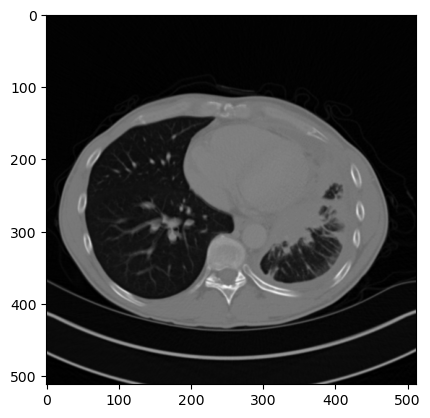

In [116]:
CT = ds.pixel_array
plt.figure()
plt.imshow(CT, cmap = "gray")

In [88]:
print("id: ", ds.ImagePositionPatient)

id:  [-174.65234375, -325.15234375, -223.7]


In [119]:
ds.dir("De-identification Method Code Sequence")
print(ds.DeidentificationMethodCodeSequence[0].CodeMeaning)

[(0008, 0100) Code Value                          SH: '113100'
(0008, 0102) Coding Scheme Designator            SH: 'DCM'
(0008, 0104) Code Meaning                        LO: 'Basic Application Confidentiality Profile'(0008, 0100) Code Value                          SH: '113101'
(0008, 0102) Coding Scheme Designator            SH: 'DCM'
(0008, 0104) Code Meaning                        LO: 'Clean Pixel Data Option'(0008, 0100) Code Value                          SH: '113104'
(0008, 0102) Coding Scheme Designator            SH: 'DCM'
(0008, 0104) Code Meaning                        LO: 'Clean Structured Content Option'(0008, 0100) Code Value                          SH: '113105'
(0008, 0102) Coding Scheme Designator            SH: 'DCM'
(0008, 0104) Code Meaning                        LO: 'Clean Descriptors Option'(0008, 0100) Code Value                          SH: '113107'
(0008, 0102) Coding Scheme Designator            SH: 'DCM'
(0008, 0104) Code Meaning                        LO: 'R

In [98]:
text = ds.DeidentificationMethod

match = re.search(r"PS (\d+\.\d+)", text)

if match:
    DeidentificationMethod = match.group(1)
    print(DeidentificationMethod)
else:
    print("No match found")


Per DICOM PS 3.15 AnnexE. Details in 0012,0064
13.15


In [134]:
dir_path = Path("/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/")

In [137]:
files = list(dir_path.glob("*"))
files

[PosixPath('/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-81.dcm'),
 PosixPath('/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-42.dcm'),
 PosixPath('/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-56.dcm'),
 PosixPath('/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-57.dcm'),
 PosixPath('/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-43.dcm'),
 PosixPath('/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-80.dcm'),
 PosixPath('/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B

In [173]:
for file in files:
    print(file)
    break

/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-81.dcm


In [138]:
CT = []

for file in files:
    dicom = pydicom.read_file(file)
    CT.append(dicom)

In [139]:
for slice in CT[:5]:
    print(slice.SliceLocation)

-623.7
-428.7
-498.7
-503.7
-433.7


In [141]:
sorted_CT = sorted(CT, key = lambda slice: slice.SliceLocation) 

for slice in sorted_CT[:5]:
    print(slice.SliceLocation)

-678.7
-673.7
-668.7
-663.7
-658.7


In [143]:
full_image = []

for slice in sorted_CT:
    full_image.append(slice.pixel_array)
    

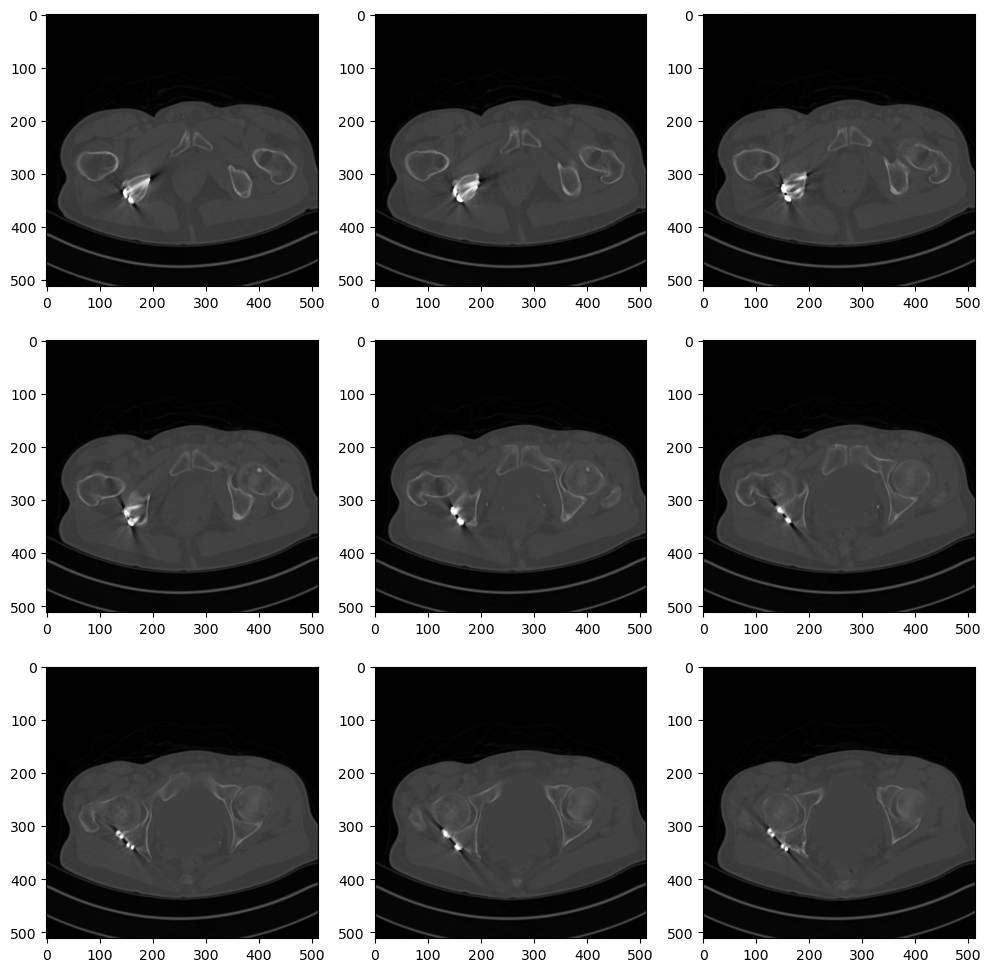

In [156]:
fig, axis = plt.subplots(3,3, figsize = (12,12))

slice_counter = 10
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(full_image[slice_counter], cmap = "gray")
        slice_counter +=1

In [161]:
series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(dir_path))
print(series_ids)

('1.3.6.1.4.1.14519.5.2.1.1610.1211.220756637617666719961067223416',)


In [164]:
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(dir_path), series_ids[0])
series_file_names

('/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-92.dcm',
 '/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-91.dcm',
 '/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-90.dcm',
 '/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-89.dcm',
 '/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-88.dcm',
 '/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-87.dcm',
 '/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-86.dcm',
 '/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-C

In [166]:
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)

In [167]:
image_data = series_reader.Execute()

CT = sitk.GetArrayFromImage(image_data)

In [168]:
CT.shape

(92, 512, 512)

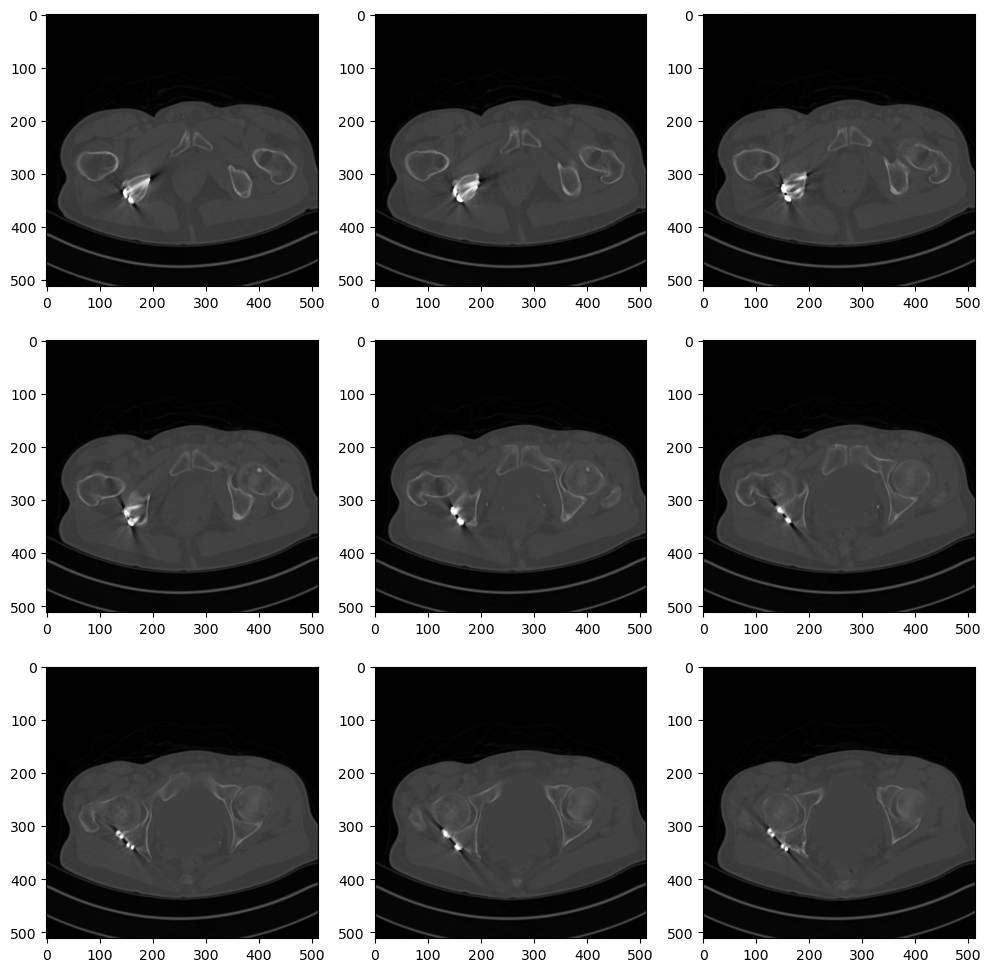

In [169]:
fig, axis = plt.subplots(3,3, figsize = (12,12))

slice_counter = 10
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(CT[slice_counter], cmap = "gray")
        slice_counter +=1

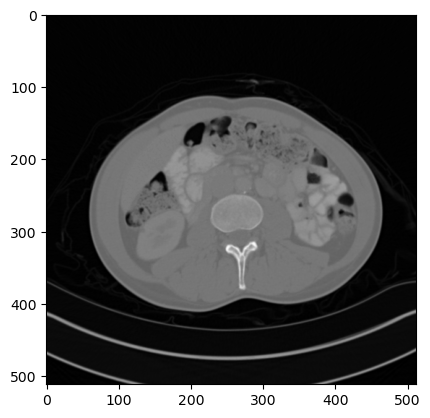

In [231]:
img_path = '/Users/kamleshranabhat/Desktop/Images/04-01-1960-NA-CT ABDOMENPELVIS W CONTRAST-03775/2.000000-AbdPelvis  5.0  B30f-23416/1-40.dcm'
dic_img = pydicom.read_file(img_path)
img_array = dic_img.pixel_array
plt.imshow(img_array, cmap = 'gray')

In [234]:
print(f"min intensity: {img_array.min()}\nmax intensity: {img_array.max()}")

min intensity: 0
max intensity: 2324


In [243]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image


In [250]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80) #bone windowing
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
 
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * brain_image
    return masked_image


In [251]:
mask = remove_noise(img_path)

plt.imshow(mask, cmap="gray")


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [3]:
# cm metadata for column :
"""
 k, n, o, p, q, r, y, z, ab, ag, ai, aj, ak, al, an, ao, ar, bx, cb, cp, cw, cx, dj, dk, dl
"""

'\n k, n, o, p, q, r, y, z, ab, ag, ai, aj, ak, al, an, ao, ar, bx, cb, cp, cw, cx, dj, dk, dl\n'

In [3]:
import pandas as pd
import os

csv_files = [
    '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200944693/12-12-1959-NA-PET1PETCTWholeBody Adult-05089/4.000000-PET WB-27733.csv', 
    '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200944693/12-12-1959-NA-PET1PETCTWholeBody Adult-05089/3.000000-CT WB FUSION-45838.csv', 
]
save_path = '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200944693/12-12-1959-NA-PET1PETCTWholeBody Adult-05089/common_output.csv'
def extract_meta(csv_files, save_path):
    columns_to_extract = ['ImageType', 'StudyDate', 'SeriesDate', 'AcquisitionDate', 'ContentDate', 'StudyTime', 'ReferringPhysicianName', 'StudyDescription', 'ManufacturerModelName', 'PatientSex', 'PatientWeight', 'AdditionalPatientHistory', 'ClinicalTrialTimePointID', 'ClinicalTrialTimePointDescription', 'LongitudinalTemporalEventType', 'PatientIdentityRemoved', 'DeidentificationMethodCodeSequence[0].CodingSchemeDesignator', 'StudyInstanceUID', 'AcquisitionNumber', 'BitsAllocated', 'WindowCenter', 'WindowWidth', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodeValue', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodingSchemeDesignator', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodeMeaning']

    cols_to_extract = ['ImageType', 'StudyDate', 'SeriesDate', 'AcquisitionDate', 'ContentDate', 'StudyTime', 'ReferringPhysicianName', 'StudyDescription', 'ManufacturerModelName', 'PatientSex', 'PatientWeight', 'AdditionalPatientHistory', 'ClinicalTrialTimePointID', 'ClinicalTrialTimePointDescription', 'LongitudinalTemporalEventType', 'PatientIdentityRemoved', 'DeidentificationMethodCodeSequence[0].CodingSchemeDesignator', 'StudyInstanceUID', 'AcquisitionNumber', 'BitsAllocated', 'WindowCenter', 'WindowWidth']
    data_frames = []
    for file in csv_files:
        df = pd.read_csv(file)
        try:
            first_row = df.loc[0, columns_to_extract].to_frame().T
        except:
            first_row = df.loc[0, cols_to_extract].to_frame().T
        data_frames.append(first_row)_

    combined_df = pd.concat(data_frames, ignore_index=True)


    combined_df.to_csv(save_path, index=False)

    print("Combined CSV file created successfully.")


Combined CSV file created successfully.


In [17]:
def extract_meta(csv_files, save_path):
    columns_to_extract = ['ImageType', 'StudyDate', 'SeriesDate', 'AcquisitionDate', 'ContentDate', 'StudyTime', 'ReferringPhysicianName', 'StudyDescription', 'ManufacturerModelName', 'PatientSex', 'PatientWeight', 'AdditionalPatientHistory', 'ClinicalTrialTimePointID', 'ClinicalTrialTimePointDescription', 'LongitudinalTemporalEventType', 'PatientIdentityRemoved', 'DeidentificationMethodCodeSequence[0].CodingSchemeDesignator', 'StudyInstanceUID', 'AcquisitionNumber', 'BitsAllocated', 'WindowCenter', 'WindowWidth', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodeValue', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodingSchemeDesignator', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodeMeaning']

    data_frames = []
    for file in csv_files:
        df = pd.read_csv(file, on_bad_lines='skip')
        first_row = df.loc[0].reindex(columns_to_extract).to_frame().T
        data_frames.append(first_row)

    combined_df = pd.concat(data_frames, ignore_index=True)
    combined_df.to_csv(save_path, index=False)

    print("Combined CSV file created successfully.")

In [36]:
main = "/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure"
dir_path = Path(main)
dir_path = list(dir_path.glob("*"))

for root in dir_path:
    if root.is_file() and root.name == '.DS_Store':
        continue
    
    sub_path = list(root.glob("*"))
    
    for sroot in sub_path:
        if sroot.is_file() and sroot.name == '.DS_Store':
            continue
        
        child_paths = list(sroot.glob("*"))
        directories = []
        
        for croot in child_paths:
            if croot.is_file() and croot.name == '.DS_Store':
                continue
            
            c_path = Path(croot)
            c_file = os.path.basename(c_path)

            file_name, file_extension = os.path.splitext(c_file)
            
            if file_extension in [".csv", ""]:
                pass
            else:
                directories.append(c_path)
                
        out_csv = f"{sroot}/common_metadata_in_columns.csv"
#         print(directories)
        csv_list = [str(directory) + '.csv' for directory in directories]
        print(csv_list)
        print(out_csv)
        try:
            extract_meta(csv_list, out_csv)
        except:
            pass
        break
#         write_common_metadata_to_csv(directories, out_csv)
#         print(f"Common metadata has been written to {out_csv}")
    break


        

['/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  LT LUNG - 1 - SEED POINT-372.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  MEDIASTINAL NODE - 2-794.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  MEDIASTINAL NODE - 1 - SEED POIN-20829.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  LT LUNG - 1-552.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  RT LUNG - 1 - SEED POINT-765.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P

In [25]:
csv_files = ['/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  LT LUNG - 1 - SEED POINT-372.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  MEDIASTINAL NODE - 2-794.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  MEDIASTINAL NODE - 1 - SEED POIN-20829.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  LT LUNG - 1-552.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  RT LUNG - 1 - SEED POINT-765.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  MEDIASTINAL NODE - 2 - SEED POIN-327.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  MEDIASTINAL NODE - 1-438.4.csv', '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/2.000000-Post-Chemotherapy 1  RT LUNG - 1-33929.csv']
save_path = '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Structure/S0819-P200936563/06-14-1960-NA-CT Chest With Contrast-14426/output.csv'

columns_to_extract = ['ImageType', 'StudyDate', 'SeriesDate', 'AcquisitionDate', 'ContentDate', 'StudyTime', 'ReferringPhysicianName', 'StudyDescription', 'ManufacturerModelName', 'PatientSex', 'PatientWeight', 'AdditionalPatientHistory', 'ClinicalTrialTimePointID', 'ClinicalTrialTimePointDescription', 'LongitudinalTemporalEventType', 'PatientIdentityRemoved', 'DeidentificationMethodCodeSequence[0].CodingSchemeDesignator', 'StudyInstanceUID', 'AcquisitionNumber', 'BitsAllocated', 'WindowCenter', 'WindowWidth', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodeValue', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodingSchemeDesignator', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodeMeaning']

data_frames = []
for file in csv_files:
    df = pd.read_csv(file)
    first_row = df.loc[0].reindex(columns_to_extract).to_frame().T
    data_frames.append(first_row)

combined_df = pd.concat(data_frames, ignore_index=True)
combined_df.to_csv(save_path, index=False)

print("Combined CSV file created successfully.")

EmptyDataError: No columns to parse from file

In [1]:
import pandas as pd

csv_file = '/Users/kamleshranabhat/Desktop/NAAMII/Sample_data/Image/S0819-P200944693/12-12-1959-NA-PET1PETCTWholeBody Adult-05089/4.000000-PET WB-27733.csv'

indices = [10, 13, 14, 15, 16, 17, 24, 25, 27, 32, 34, 35, 36, 37, 39, 40, 43, 75, 79, 93, 100, 101, 113, 114, 115]
#  k, n, o, p, q, r, y, z, ab, ag, ai, aj, ak, al, an, ao, ar, bx, cb, cp, cw, cx, dj, dk, dl
df = pd.read_csv(csv_file)

columns = df.columns
lest = []

for index in indices:
    if index < len(columns):
        lest.append(columns[index])
        print(f"Column at index {index}: {columns[index]}")
    else:
        print(f"Index {index} is out of range for the columns in the CSV file.")
        
print(lest)

Column at index 10: ImageType
Column at index 13: StudyDate
Column at index 14: SeriesDate
Column at index 15: AcquisitionDate
Column at index 16: ContentDate
Column at index 17: StudyTime
Column at index 24: ReferringPhysicianName
Column at index 25: StudyDescription
Column at index 27: ManufacturerModelName
Column at index 32: PatientSex
Column at index 34: PatientWeight
Column at index 35: AdditionalPatientHistory
Column at index 36: ClinicalTrialTimePointID
Column at index 37: ClinicalTrialTimePointDescription
Column at index 39: LongitudinalTemporalEventType
Column at index 40: PatientIdentityRemoved
Column at index 43: DeidentificationMethodCodeSequence[0].CodingSchemeDesignator
Column at index 75: StudyInstanceUID
Column at index 79: AcquisitionNumber
Column at index 93: BitsAllocated
Column at index 100: WindowCenter
Column at index 101: WindowWidth
Column at index 113: RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodeValue
Column at index 114: Radiopha

In [ ]:
columns_to_extract = ['ImageType', 'StudyDate', 'SeriesDate', 'AcquisitionDate', 'ContentDate', 'StudyTime', 'ReferringPhysicianName', 'StudyDescription', 'ManufacturerModelName', 'PatientSex', 'PatientWeight', 'AdditionalPatientHistory', 'ClinicalTrialTimePointID', 'ClinicalTrialTimePointDescription', 'LongitudinalTemporalEventType', 'PatientIdentityRemoved', 'DeidentificationMethodCodeSequence[0].CodingSchemeDesignator', 'StudyInstanceUID', 'AcquisitionNumber', 'BitsAllocated', 'WindowCenter', 'WindowWidth', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodeValue', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodingSchemeDesignator', 'RadiopharmaceuticalInformationSequence[0].RadionuclideCodeSequence[0].CodeMeaning']# Update with the columns you want to extract
